# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

**DOUBTS**
- Calcolare alpha e beta per ogni stazione con il fit di scipy? Vanno messe due nuove colonne nel dataset? Se c'è una sola osservazione non posso fare il fit => uniforme? (alpha=1, beta=1)
- Output: AMS o alpha e beta?
- Initial guess? 
- Alpha e beta predetti per ogni stazione come vanno paragonati con quelli "veri"? Intervallo di confidenza sulla media o sui parametri (questo come si calcola) ?
- Come si fa inferenza su più distribuzioni? Quali metriche?
- 20 epoche e 2 hidden impara come 2 epoche e 0 hidden

**TO DO**
- provare con solo MAP in input
- pca?
- nel test ogni stazione ha senso che ci sia una sola volta, tanto l'output sarà sempre lo stesso


# 0. Importing libraries

In [2]:
colab = False

if colab:
    !pip install fitter
    !pip install pydot
    !pip install graphviz
    from pathlib import Path
    from google.colab import drive
    drive.mount('/content/drive')

import pandas as pd
import numpy as np
from itertools import chain
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy import stats

from utils import util

2024-02-23 15:42:35.128873: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
from importlib import reload  
from utils import util
util = reload(util)

# 1. Load and inspect the dataset

## 1.1. Load data

In [4]:
df, df_indexes_test = util.load_data(colab)
print(df.columns)

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


In [5]:
df.head()

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679


In [6]:
# Clean the dataset from the columns that are not useful
to_remove = ['Nome', '99perc', '95perc', '80perc']
df = df.drop(to_remove, axis=1, inplace=False)

# Unique duration values
DURATION = df['duration[h]'].unique()
print('Durations: ', DURATION)

Durations:  [ 1  3  6 12 24]


## 1.2. Preprocess and split the dataset

### Split the dataset into train, validation and test

In [7]:
# Take the first 100 ID and use them to create the test sets
test_ID = df_indexes_test['ID'].to_list()[:100]

test_df = df[df['ID'].isin(test_ID)]
test_df.reset_index(drop=True, inplace=True)

# Drop the test set from df and then create the train sets and validation sets
df = df.drop(df[df['ID'].isin(test_ID)].index)
df.reset_index(drop=True, inplace=True)

validation_split = 0.1
df = df.sort_values(by=['ID'])

train_df, val_df = train_test_split(df, test_size=validation_split, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [8]:
train_df.head()

,ID,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),...,MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h],AMS,mean_IdD,loc,scale
0,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,1,1.221239,28.250,0.890564,0.184415
1,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,24,0.680425,199.875,0.859361,0.219803
2,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,24,0.855535,199.875,0.859361,0.219803
3,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,24,0.945591,199.875,0.859361,0.219803
4,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,24,1.518449,199.875,0.859361,0.219803


### Standardize datasets

In [9]:
train_df_std = util.standardize(train_df, 'gumbel')
val_df_std = util.standardize(val_df, 'gumbel')
test_df_std = util.standardize(test_df, 'gumbel')

In [10]:
# column ID must be integer
train_df_std['ID'] = train_df_std['ID'].astype(int)
val_df_std['ID'] = val_df_std['ID'].astype(int)
test_df_std['ID'] = test_df_std['ID'].astype(int)

# column duration[h] must be integer
train_df_std['duration[h]'] = train_df_std['duration[h]'].astype(int)
val_df_std['duration[h]'] = val_df_std['duration[h]'].astype(int)
test_df_std['duration[h]'] = test_df_std['duration[h]'].astype(int)

In [11]:
train_df_std.head()

,ID,AMS,mean_IdD,loc,scale,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001,1.221239,28.250,0.890564,0.184415,1,1.491097,0.251105,0.104265,-0.433165,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267
1,5001,0.680425,199.875,0.859361,0.219803,24,1.491097,0.251105,0.104265,-0.433165,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267
2,5001,0.855535,199.875,0.859361,0.219803,24,1.491097,0.251105,0.104265,-0.433165,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267
3,5001,0.945591,199.875,0.859361,0.219803,24,1.491097,0.251105,0.104265,-0.433165,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267
4,5001,1.518449,199.875,0.859361,0.219803,24,1.491097,0.251105,0.104265,-0.433165,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267


In [12]:
train_df_std.describe()

,ID,AMS,mean_IdD,loc,scale,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
count,233218.000000,233218.000000,233218.000000,233218.000000,2.332180e+05,233218.000000,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,...,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05
mean,11047.209328,0.999994,57.052651,0.840404,2.670913e-01,9.199200,7.507042e-17,7.409548e-17,-3.314798e-17,3.197805e-16,...,-4.523724e-16,-2.412978e-16,1.774392e-16,7.799524e-17,-7.019572e-17,1.413664e-17,-2.924822e-18,1.160179e-16,8.111505e-16,-5.490865e-15
std,4333.130131,0.375311,31.051531,0.034366,5.204271e-02,8.280664,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,5001.000000,0.008228,5.200000,0.563792,6.394417e-304,1.000000,-1.061720e+00,-1.230453e+00,-1.400119e+00,-1.588764e+00,...,-1.386613e+00,-1.471702e+00,-1.677331e+00,-1.834339e+00,-1.613136e+00,-4.798978e-01,-1.574433e+00,-6.312755e-01,-1.985384e+00,-1.780799e+00
25%,8094.000000,0.746687,34.984444,0.820754,2.357013e-01,3.000000,-7.450225e-01,-8.616555e-01,-9.477065e-01,-7.307816e-01,...,-8.936858e-01,-5.806414e-01,-7.799818e-01,-7.189705e-01,-7.835092e-01,-4.531067e-01,-8.066373e-01,-5.114469e-01,-9.065087e-01,-7.796086e-01
50%,12005.000000,0.931278,49.674286,0.841520,2.668687e-01,6.000000,-2.934347e-01,-1.262639e-01,3.152787e-02,7.104603e-02,...,-4.642899e-02,-1.402476e-01,-1.361465e-01,-1.810079e-01,-2.345443e-01,-4.210953e-01,-2.259545e-01,-4.328924e-01,1.538823e-01,-2.911280e-01
75%,16065.000000,1.171738,70.343750,0.862298,2.976202e-01,12.000000,4.626625e-01,6.164214e-01,7.001068e-01,6.817685e-01,...,6.758903e-01,3.750492e-01,6.410975e-01,5.143236e-01,5.747680e-01,-2.262652e-01,6.329709e-01,-9.903266e-02,7.807107e-01,7.872395e-01
max,20034.000000,6.288661,318.742857,1.000000,6.725157e-01,24.000000,5.303011e+00,3.753508e+00,2.939412e+00,3.556897e+00,...,2.546467e+00,5.233349e+00,3.650529e+00,3.278702e+00,4.315496e+00,7.291909e+00,3.516737e+00,6.103627e+00,2.150008e+00,2.505157e+00


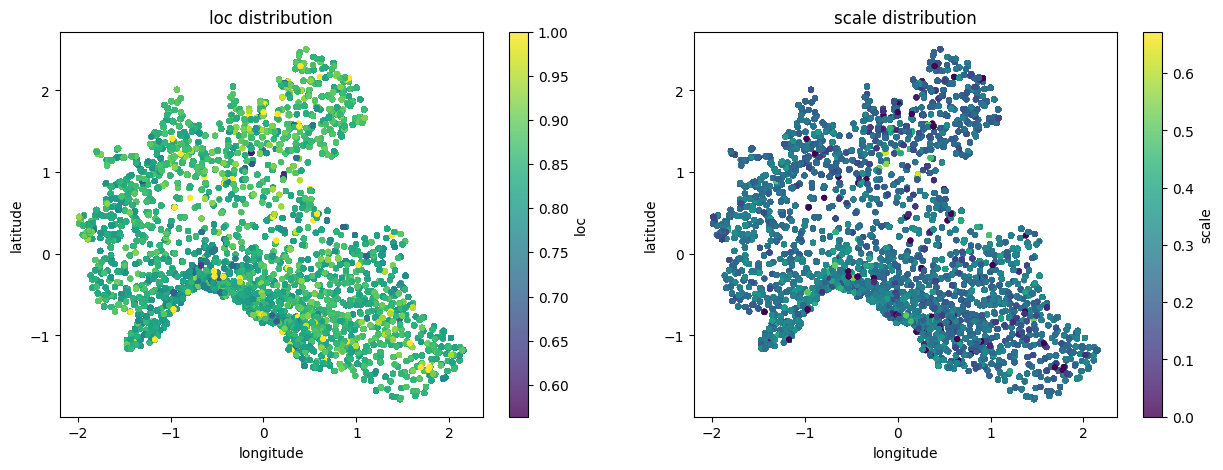

In [13]:
util.geographic_plot(train_df_std, 'loc', 'scale')

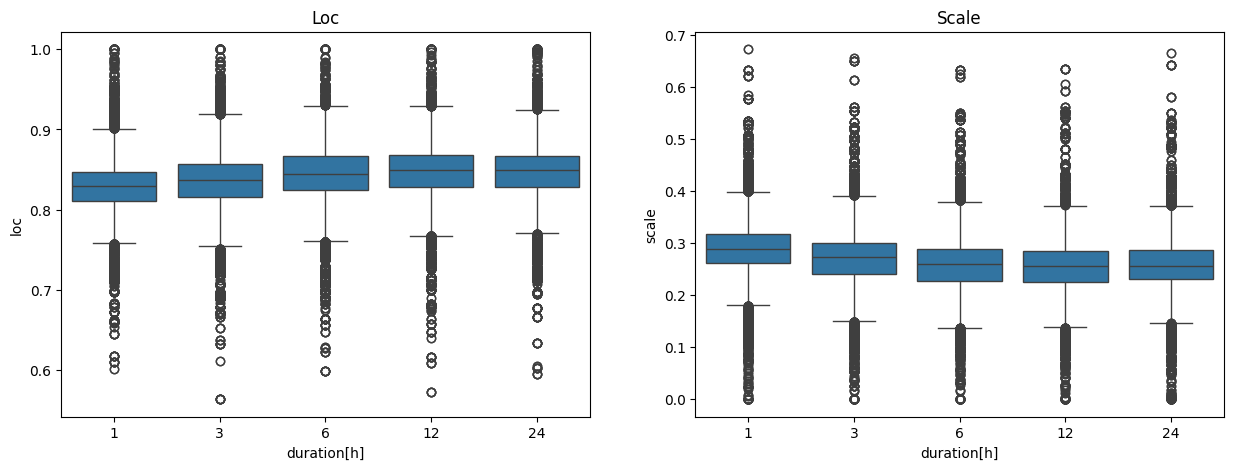

In [14]:
#boxplot of loc and scale
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x='duration[h]', y='loc', data=train_df_std, ax=ax[0])
ax[0].set_title('Loc')

sns.boxplot(x='duration[h]', y='scale', data=train_df_std, ax=ax[1])
ax[1].set_title('Scale')

plt.show()

In [15]:
AMS_count = train_df_std.groupby(['ID','duration[h]'])['AMS'].count()
AMS_count = pd.DataFrame(AMS_count)
AMS_count.columns = ['count']
AMS_count['loc'] = train_df_std.groupby(['ID','duration[h]'])['loc'].mean() #prendo la media tanto lo stesso valore è ripetuto
AMS_count['scale'] = train_df_std.groupby(['ID','duration[h]'])['scale'].mean()

AMS_count.head(15)

count       loc     scale
ID   duration[h]                           
5001 1                2  0.890564  0.184415
     3                4  0.925308  0.129267
     6                4  0.932067  0.124795
     12               4  0.906658  0.175087
     24               4  0.859361  0.219803
5002 1               23  0.823918  0.287186
     3               23  0.783417  0.300108
     6               23  0.782840  0.333148
     12              23  0.804177  0.335036
     24              23  0.788515  0.355437
5003 1               55  0.820118  0.333625
     3               56  0.802589  0.378693
     6               56  0.806101  0.377994
     12              56  0.817565  0.370967
     24              56  0.818996  0.371627

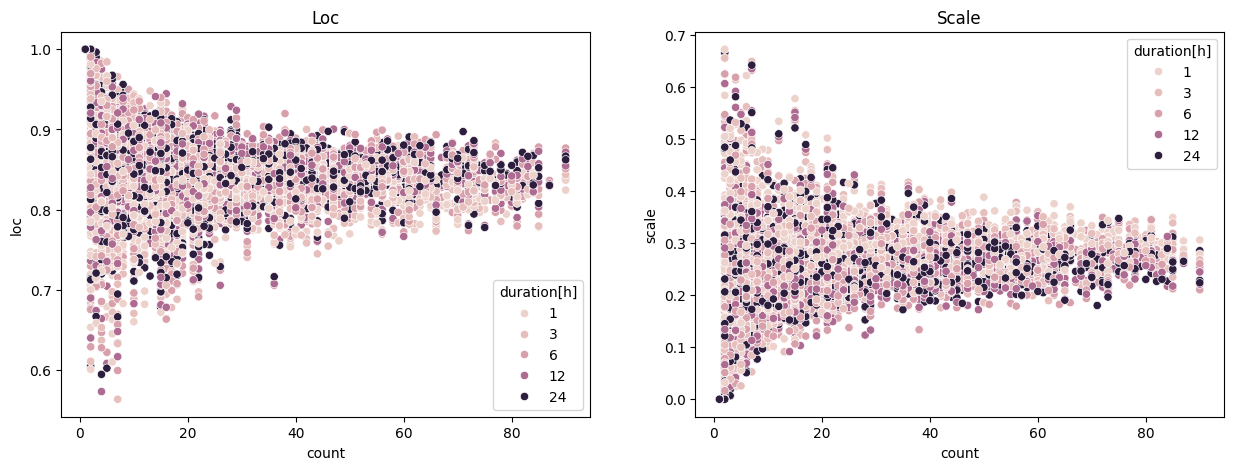

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x='count', y='loc', data=AMS_count, ax=ax[0], hue='duration[h]')
ax[0].set_title('Loc')

sns.scatterplot(x='count', y='scale', data=AMS_count, ax=ax[1], hue='duration[h]')
ax[1].set_title('Scale')

plt.show()

## 1.4. Prepare data for training

In [17]:
# sort the dataframes by ID and then by duration
train_df_std = train_df_std.sort_values(by=['ID', 'duration[h]'])
val_df_std = val_df_std.sort_values(by=['ID', 'duration[h]'])
test_df_std = test_df_std.sort_values(by=['ID', 'duration[h]'])

# create a dict to store the indexes of same durations
durations_indexes_train = {}
for duration in DURATION:
    durations_indexes_train[duration] = train_df_std[train_df_std['duration[h]'] == duration].index

durations_indexes_val = {}
for duration in DURATION:
    durations_indexes_val[duration] = val_df_std[val_df_std['duration[h]'] == duration].index

durations_indexes_test = {}
for duration in DURATION:
    durations_indexes_test[duration] = test_df_std[test_df_std['duration[h]'] == duration].index

In [18]:
train_df_std.columns

Index(['ID', 'AMS', 'mean_IdD', 'loc', 'scale', 'duration[h]',
       'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')

In [19]:
# take all the columns except 'ID', 'AMS', 'mean_IdD' as input, and 'AMS' as output
columns = train_df_std.columns
input_columns = columns[5:]  
output_column = 'AMS'
parameters_columns = ['ID', 'duration[h]', 'loc', 'scale']
print('Input columns: ', input_columns)

Input columns:  Index(['duration[h]', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [20]:
inputs_train = train_df_std[input_columns]
outputs_train = train_df_std[output_column]
parameters_train = train_df_std[parameters_columns]

inputs_val = val_df_std[input_columns]
outputs_val = val_df_std[output_column]
parameters_val = val_df_std[parameters_columns]

inputs_test = test_df_std[input_columns]
outputs_test = test_df_std[output_column]
parameters_test = test_df_std[parameters_columns]

In [21]:
#make ohe for duration

inputs_train = pd.get_dummies(inputs_train, columns=['duration[h]'])
inputs_val = pd.get_dummies(inputs_val, columns=['duration[h]'])
inputs_test = pd.get_dummies(inputs_test, columns=['duration[h]'])

for duration in DURATION:
    inputs_train['duration[h]_'+str(duration)] = inputs_train['duration[h]_'+str(duration)].astype(int)
    inputs_val['duration[h]_'+str(duration)] = inputs_val['duration[h]_'+str(duration)].astype(int)
    inputs_test['duration[h]_'+str(duration)] = inputs_test['duration[h]_'+str(duration)].astype(int)

inputs_train

,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),OrogrAdri_max(m),...,MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
0,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,0.637867,...,4.627821,1.780453,4.585390,0.512238,-0.713267,1,0,0,0,0
15,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,0.637867,...,4.627821,1.780453,4.585390,0.512238,-0.713267,1,0,0,0,0
5,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,0.637867,...,4.627821,1.780453,4.585390,0.512238,-0.713267,0,1,0,0,0
6,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,0.637867,...,4.627821,1.780453,4.585390,0.512238,-0.713267,0,1,0,0,0
7,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,0.637867,...,4.627821,1.780453,4.585390,0.512238,-0.713267,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233201,1.385034,0.772005,0.693361,1.147691,-0.492610,0.078161,1.879655,0.615505,1.600197,1.960265,...,1.500728,0.805394,1.653221,-1.793283,1.246819,0,0,0,0,1
233202,1.385034,0.772005,0.693361,1.147691,-0.492610,0.078161,1.879655,0.615505,1.600197,1.960265,...,1.500728,0.805394,1.653221,-1.793283,1.246819,0,0,0,0,1
233203,1.385034,0.772005,0.693361,1.147691,-0.492610,0.078161,1.879655,0.615505,1.600197,1.960265,...,1.500728,0.805394,1.653221,-1.793283,1.246819,0,0,0,0,1
233204,1.385034,0.772005,0.693361,1.147691,-0.492610,0.078161,1.879655,0.615505,1.600197,1.960265,...,1.500728,0.805394,1.653221,-1.793283,1.246819,0,0,0,0,1


In [22]:
#MAP
inputs_train_map = inputs_train[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_val_map = inputs_val[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_test_map = inputs_test[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]

inputs_train_map

,MAP(mm),duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
0,2.169919,1,0,0,0,0
15,2.169919,1,0,0,0,0
5,2.169919,0,1,0,0,0
6,2.169919,0,1,0,0,0
7,2.169919,0,1,0,0,0
...,...,...,...,...,...,...
233201,-0.149450,0,0,0,0,1
233202,-0.149450,0,0,0,0,1
233203,-0.149450,0,0,0,0,1
233204,-0.149450,0,0,0,0,1


In [23]:
#PCA
inputs_train_pca = util.make_pca(inputs_train, 5)
inputs_val_pca = util.make_pca(inputs_val, 5)
inputs_test_pca = util.make_pca(inputs_test, 5)

inputs_train_pca


,0,1,2,3,4
0,4.026139,-0.292017,-1.023797,5.180255,0.373488
1,4.026139,-0.292017,-1.023797,5.180255,0.373488
2,4.026145,-0.292061,-1.023846,5.180428,0.373524
3,4.026145,-0.292061,-1.023846,5.180428,0.373524
4,4.026145,-0.292061,-1.023846,5.180428,0.373524
...,...,...,...,...,...
233213,5.923551,1.971400,2.285805,-0.279601,0.049549
233214,5.923551,1.971400,2.285805,-0.279601,0.049549
233215,5.923551,1.971400,2.285805,-0.279601,0.049549
233216,5.923551,1.971400,2.285805,-0.279601,0.049549


# 2. Model definition

#### Base model

In [24]:
def build_nn_gumbel_model(input_shape, hidden):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    
    mu_logsig = layers.Dense(2, activation='linear')(x)

    lf = lambda t: tfp.distributions.Gumbel(loc=t[:, :1], scale=(1e-6)+tf.math.exp(t[:, 1:]))
    model_out = tfp.layers.DistributionLambda(lf)(mu_logsig)
    model = keras.Model(model_in, model_out)
    
    return model

# 3. Training

## Training

In [25]:
y_train  = outputs_train.values
y_val = outputs_val.values
y_test = outputs_test.values

In [26]:
# Parameters for the training
batch_size = 512
epochs = 90 
lr = 1e-3
patience = 30
loss_prof = lambda y_true, dist: -dist.log_prob(y_true)

* MAP-model

Training the model with only MAP descriptor...
Epoch 1/90
456/456 [==============================] - 2s 2ms/step - loss: 0.3414 - val_loss: 0.2670
Epoch 2/90
456/456 [==============================] - 1s 2ms/step - loss: 0.3096 - val_loss: 0.2650
Epoch 3/90
456/456 [==============================] - 1s 2ms/step - loss: 0.3096 - val_loss: 0.2615
Epoch 4/90
456/456 [==============================] - 1s 2ms/step - loss: 0.3092 - val_loss: 0.2613
Epoch 5/90
456/456 [==============================] - 1s 2ms/step - loss: 0.3087 - val_loss: 0.2620
Epoch 6/90
456/456 [==============================] - 1s 2ms/step - loss: 0.3084 - val_loss: 0.2647
Epoch 7/90
456/456 [==============================] - 1s 2ms/step - loss: 0.3077 - val_loss: 0.2658
Epoch 8/90
456/456 [==============================] - 1s 2ms/step - loss: 0.3078 - val_loss: 0.2671
Epoch 9/90
456/456 [==============================] - 1s 2ms/step - loss: 0.3079 - val_loss: 0.2617
Epoch 10/90
456/456 [==============================] 

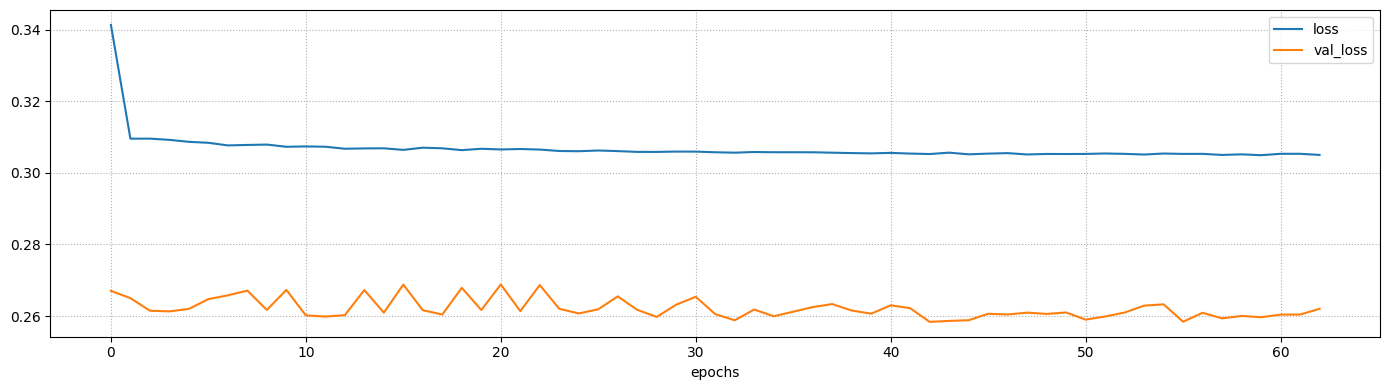

Final loss: 0.3050 (training), 0.2620 (validation)


In [27]:
X_train_map = inputs_train_map.values
X_val_map = inputs_val_map.values
X_test_map = inputs_test_map.values

print('Training the model with only MAP descriptor...')
map_model = build_nn_gumbel_model(input_shape=(X_train_map.shape[1],), hidden=[128,256]) #[256,128]
history = util.train_nn_model(map_model, X_train_map, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_map, y_val))
util.plot_training_history(history, figsize=(14, 4))

* Full-model

Training the model with all morphoclimatic descriptors...
Epoch 1/90
456/456 [==============================] - 2s 2ms/step - loss: 0.3525 - val_loss: 0.4470
Epoch 2/90
456/456 [==============================] - 1s 2ms/step - loss: 0.3073 - val_loss: 0.4113
Epoch 3/90
456/456 [==============================] - 1s 3ms/step - loss: 0.3030 - val_loss: 0.6258
Epoch 4/90
456/456 [==============================] - 1s 2ms/step - loss: 0.2992 - val_loss: 0.4357
Epoch 5/90
456/456 [==============================] - 1s 2ms/step - loss: 0.2970 - val_loss: 0.5767
Epoch 6/90
456/456 [==============================] - 1s 2ms/step - loss: 0.2956 - val_loss: 0.4577
Epoch 7/90
456/456 [==============================] - 1s 2ms/step - loss: 0.2948 - val_loss: 0.5876
Epoch 8/90
456/456 [==============================] - 1s 2ms/step - loss: 0.2929 - val_loss: 0.4366
Epoch 9/90
456/456 [==============================] - 1s 3ms/step - loss: 0.2919 - val_loss: 0.4173
Epoch 10/90
456/456 [=====================

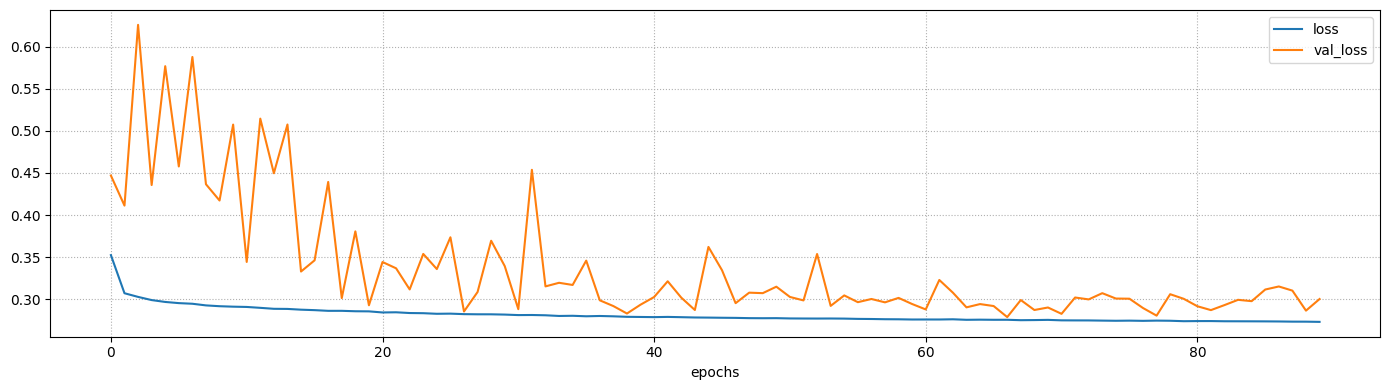

Final loss: 0.2733 (training), 0.3004 (validation)


In [28]:
X_train = inputs_train.values
X_val = inputs_val.values
X_test = inputs_test.values

print('Training the model with all morphoclimatic descriptors...')
full_model = build_nn_gumbel_model(input_shape=(X_train.shape[1],), hidden=[128,256]) #[256,128]
history = util.train_nn_model(full_model, X_train, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val, y_val))
util.plot_training_history(history, figsize=(14, 4))

* PCA-model

Training the model with the PCA of the morphoclimatic descriptors...
Epoch 1/90
456/456 [==============================] - 2s 3ms/step - loss: 0.3681 - val_loss: 0.4549
Epoch 2/90
456/456 [==============================] - 1s 2ms/step - loss: 0.3115 - val_loss: 0.3559
Epoch 3/90
456/456 [==============================] - 1s 2ms/step - loss: 0.3062 - val_loss: 0.3124
Epoch 4/90
456/456 [==============================] - 1s 2ms/step - loss: 0.3049 - val_loss: 0.3047
Epoch 5/90
456/456 [==============================] - 1s 2ms/step - loss: 0.3022 - val_loss: 0.2927
Epoch 6/90
456/456 [==============================] - 1s 3ms/step - loss: 0.3022 - val_loss: 0.2979
Epoch 7/90
456/456 [==============================] - 1s 2ms/step - loss: 0.3009 - val_loss: 0.2825
Epoch 8/90
456/456 [==============================] - 1s 2ms/step - loss: 0.3017 - val_loss: 0.2800
Epoch 9/90
456/456 [==============================] - 1s 2ms/step - loss: 0.3000 - val_loss: 0.2810
Epoch 10/90
456/456 [==========

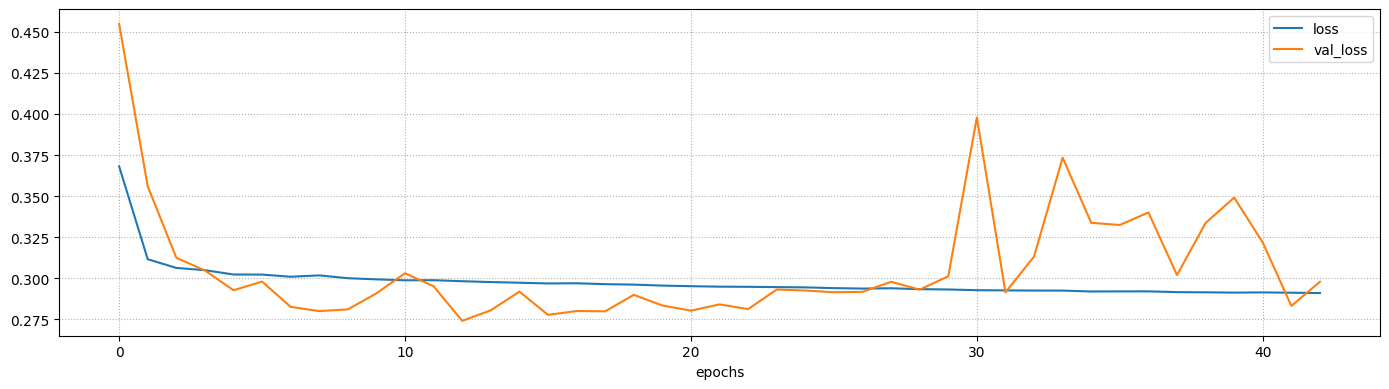

Final loss: 0.2909 (training), 0.2978 (validation)


In [30]:
X_train_pca = inputs_train_pca.values
X_val_pca = inputs_val_pca.values
X_test_pca = inputs_test_pca.values

print('Training the model with the PCA of the morphoclimatic descriptors...')
pca_model = build_nn_gumbel_model(input_shape=(X_train_pca.shape[1],), hidden=[128,256]) #[256,128]
history = util.train_nn_model(pca_model, X_train_pca, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_pca, y_val))
util.plot_training_history(history, figsize=(14, 4))

# Evaluation

In [36]:
results = pd.DataFrame()

* MAP-model evaluation

Evaluating the Map-model on Train set...


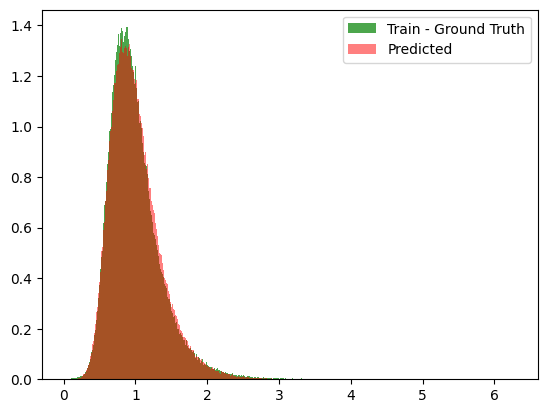

In [37]:
model_name = 'Map-model'

split = 'Train'
results[0] = util.evaluation(map_model, X_train_map, y_train, model_name, split)
dist_train_map = map_model(X_train_map)

Evaluating the Map-model on Val set...


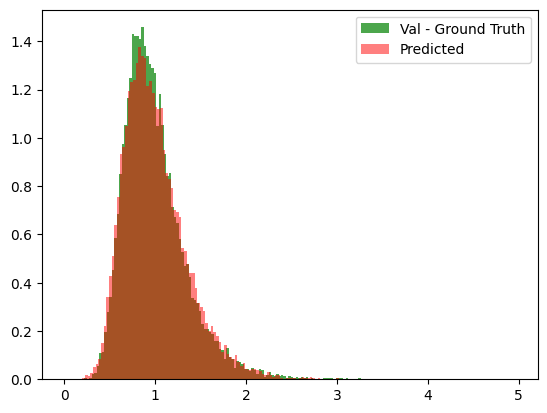

In [38]:
split = 'Val'
results[1] = util.evaluation(map_model, X_val_map, y_val, model_name, split)
dist_val_map = map_model(X_val_map)

Evaluating the Map-model on Test set...


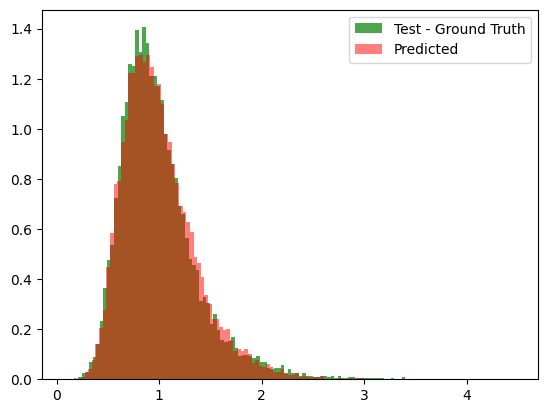

In [39]:
split = 'Test'
results[2] = util.evaluation(map_model, X_test_map, y_test, model_name, split)
dist_test_map = map_model(X_test_map)

* Full-model evaluation

Evaluating the Full-model on Train set...


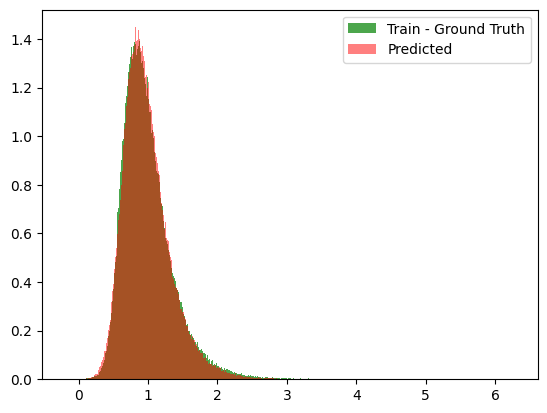

In [40]:
model_name = 'Full-model'

split = 'Train'
results[3] = util.evaluation(full_model, X_train, y_train, model_name, split)
dist_train_full = full_model(X_train)

Evaluating the Full-model on Val set...


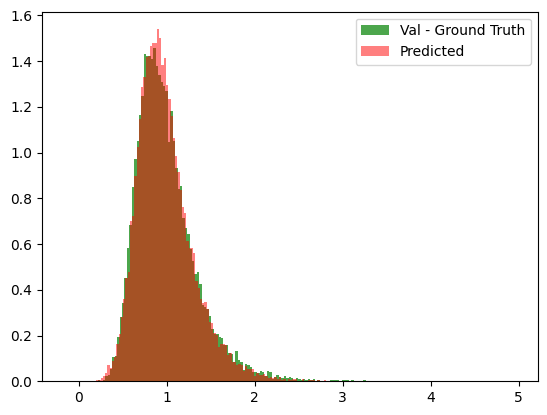

In [41]:
split = 'Val'
results[4] = util.evaluation(full_model, X_val, y_val, model_name, split)
dist_val_full = full_model(X_val)

Evaluating the Full-model on Test set...


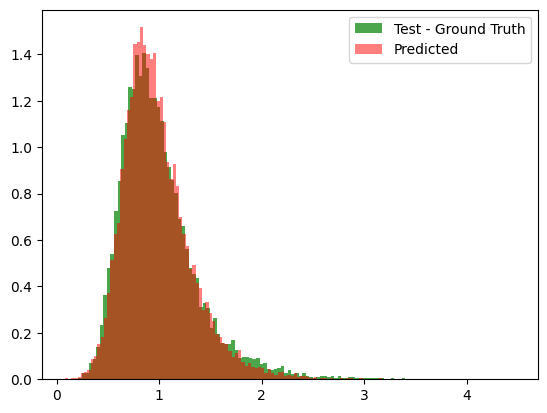

In [42]:
split = 'Test'
results[5] = util.evaluation(full_model, X_test, y_test, model_name, split)
dist_test_full = full_model(X_test)

* PCA-model evaluation

Evaluating the Pca-model on Train set...


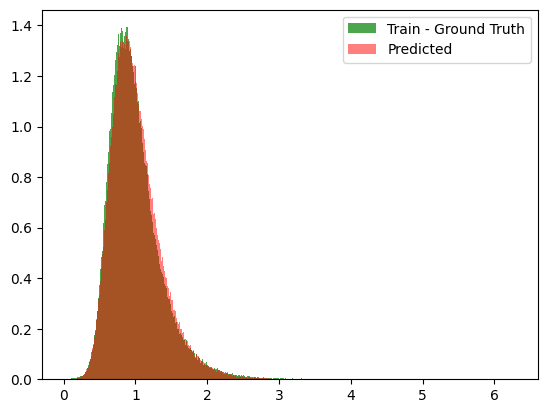

In [43]:
model_name = 'Pca-model'

split = 'Train'
results[6] = util.evaluation(pca_model, X_train_pca, y_train, model_name, split)
dist_train_pca = pca_model(X_train_pca)

Evaluating the Pca-model on Val set...


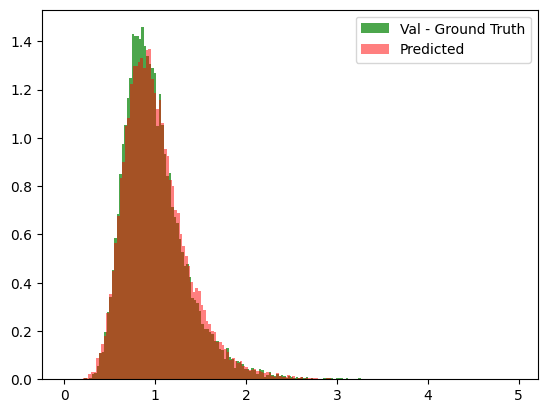

In [44]:
split = 'Val'
results[7] = util.evaluation(pca_model, X_val_pca, y_val, model_name, split)
dist_val_pca = pca_model(X_val_pca)

Evaluating the Pca-model on Test set...


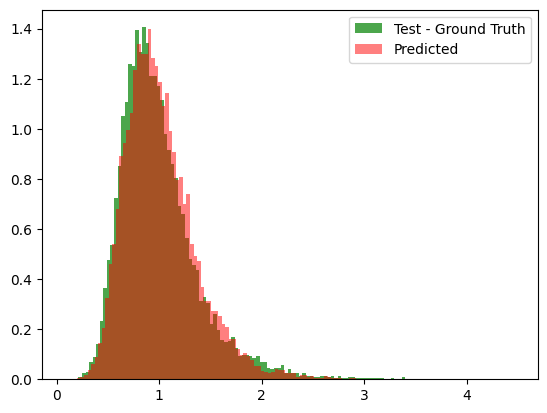

In [45]:
split = 'Test'
results[8] = util.evaluation(pca_model, X_test_pca, y_test, model_name, split)
dist_test_pca = pca_model(X_test_pca)

In [50]:
results = results.T
results.columns=['Split', 'MAE', 'KS statistics']
display(results)

,Split,MAE,KS statistics
0,Train,0.389404,0.020213
1,Val,0.380966,0.02134
2,Test,0.396076,0.021148
3,Train,0.379852,0.013065
4,Val,0.36027,0.017519
5,Test,0.384604,0.024132
6,Train,0.387443,0.028283
7,Val,0.377522,0.030254
8,Test,0.390561,0.050341


### Distribution mean - confidence interval 

In [51]:
confidence = 0.99

Evaluation of Map-model based on confidence intervals..


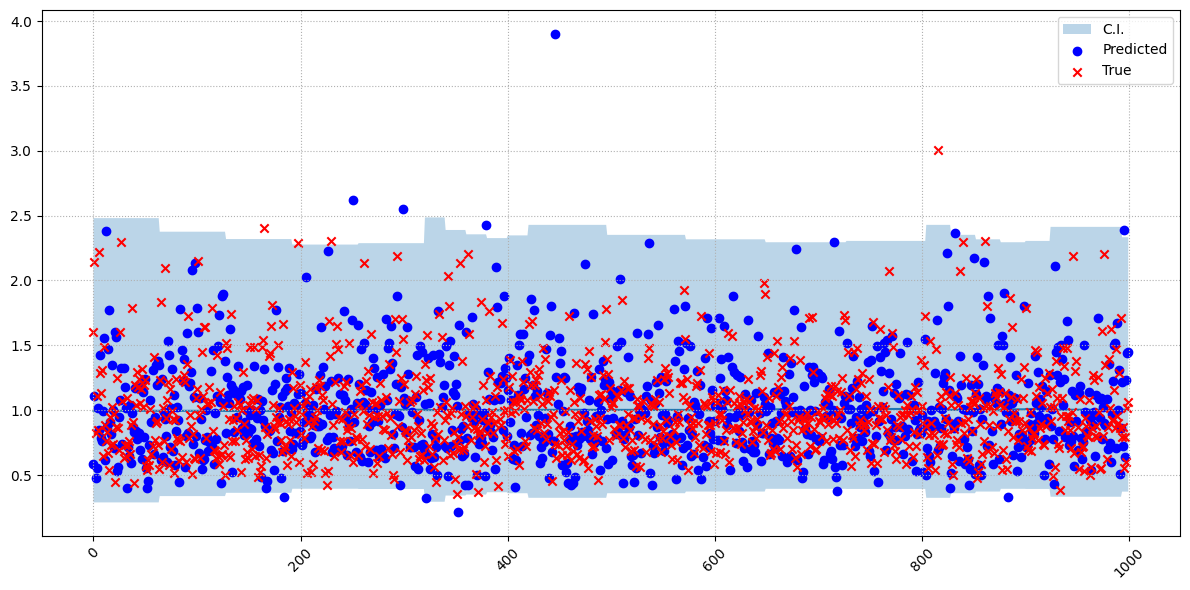

Percentage of values inside the 99% confidence interval: 98.38%


In [55]:
print('Evaluation of MAP-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_map, y_test, dist_test_map, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of Full-model based on confidence intervals..


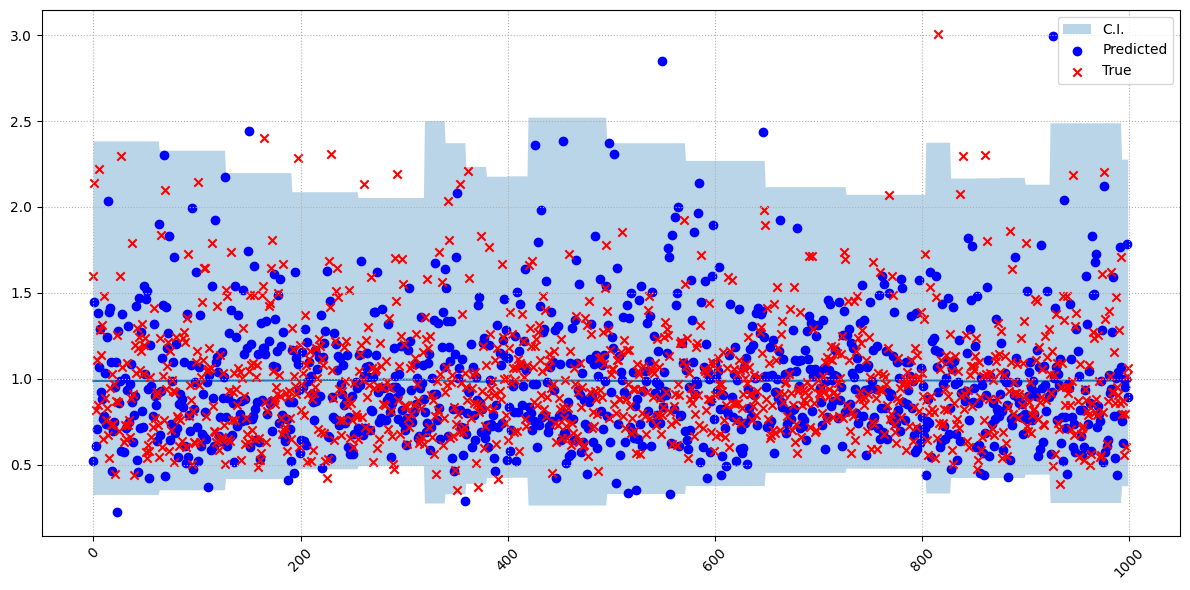

Percentage of values inside the 99% confidence interval: 96.98%


In [56]:
print('Evaluation of Full-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test, y_test, dist_test_full, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of Pca-model based on confidence intervals..


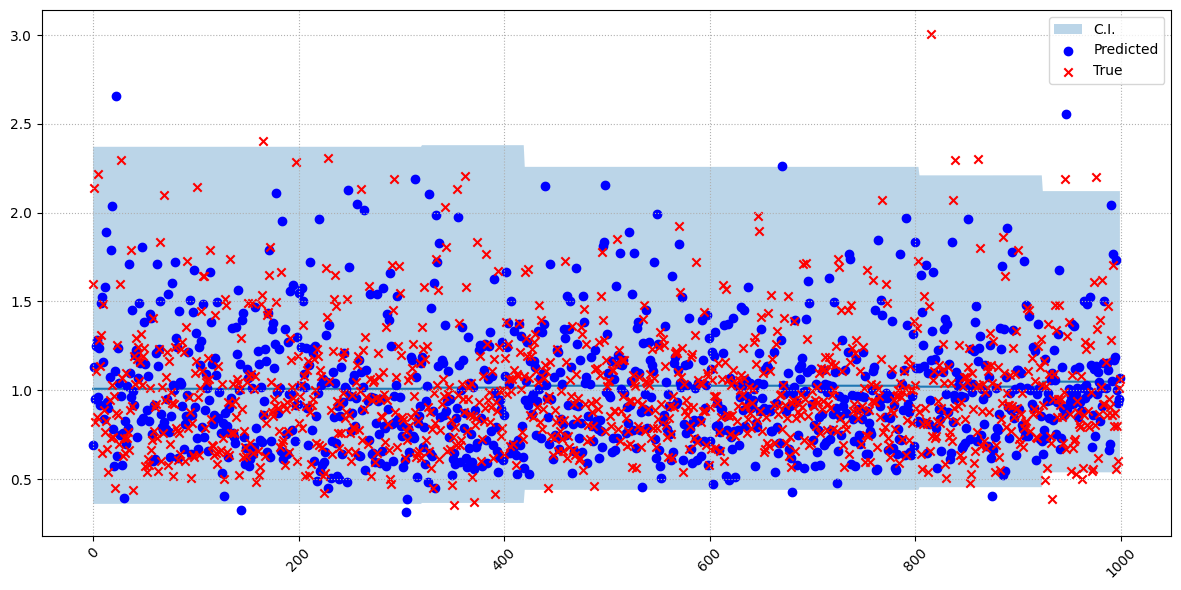

Percentage of values inside the 99% confidence interval: 97.39%


In [57]:
print('Evaluation of PCA-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_pca, y_test, dist_test_pca, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

# Parameters

* Metrics on parameters from MAP-model

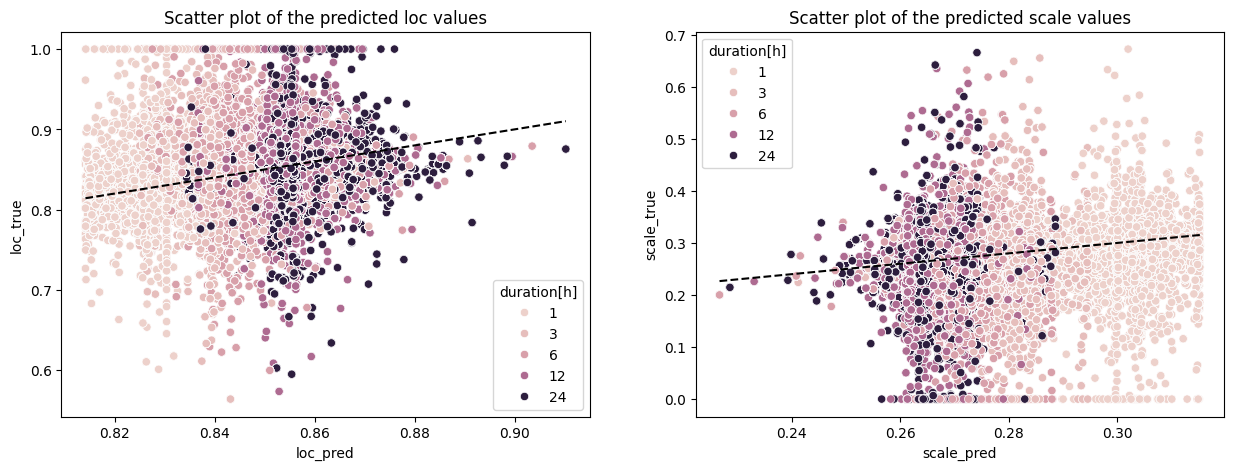

In [58]:
_ = util.parameters_metrics(dist_train_map, parameters_train, distribution_name = 'gumbel', calculate_metrics = False)

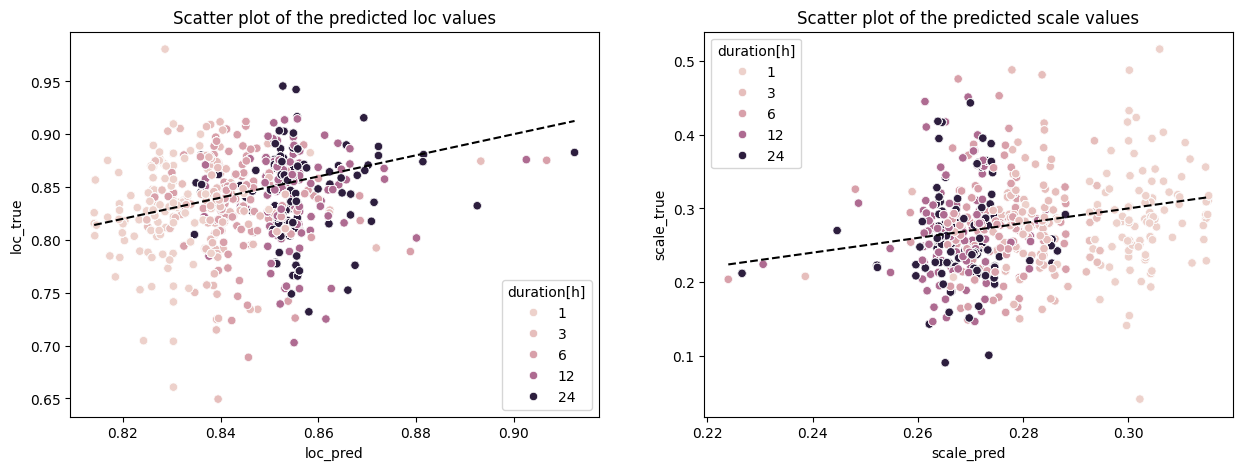

In [59]:
metrics_loc_map, metrics_scale_map = util.parameters_metrics(dist_test_map, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [60]:
print('===============LOC PARAMETER===============')
metrics_loc_map

===============LOC PARAMETER===============


,global,1,3,6,12,24
biasr,-0.011816,-0.005984,-0.013379,-0.008981,-0.015932,-0.014813
rmse,0.001277,0.001152,0.001375,0.001351,0.001314,0.001194
pcc,0.188617,0.157420,-0.019037,-0.027096,0.013074,0.062389


In [61]:
print('===============SCALE PARAMETER==============')
metrics_scale_map

===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,-0.052237,-0.067546,-0.040544,-0.054927,-0.043033,-0.055131
rmse,0.002309,0.002449,0.002281,0.002346,0.002289,0.002179
pcc,0.252773,0.139519,-0.016608,0.047133,0.086720,0.070021


* Metrics on parameters from Full-model

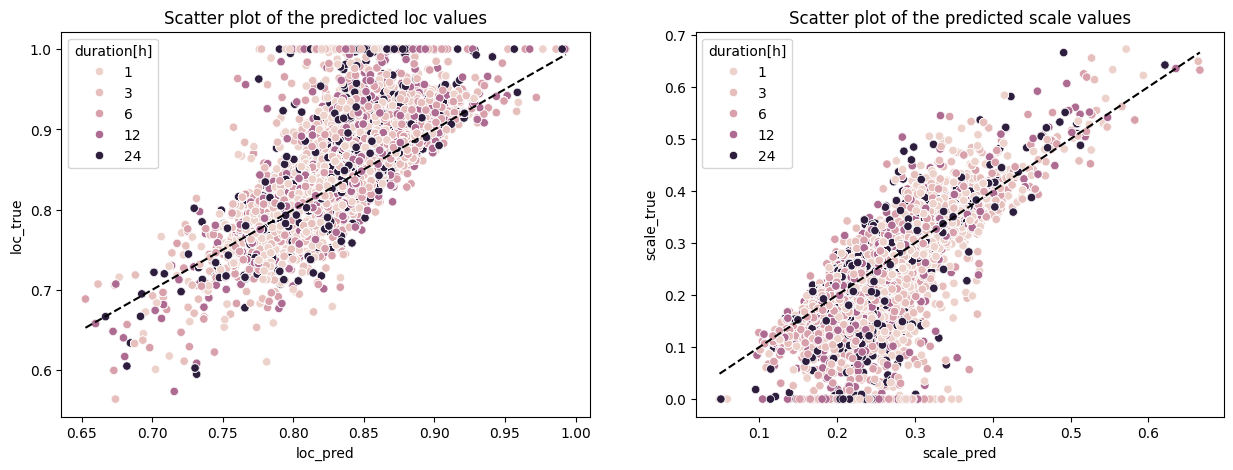

In [63]:
_ = util.parameters_metrics(dist_train_full, parameters_train, distribution_name = 'gumbel', calculate_metrics = False)

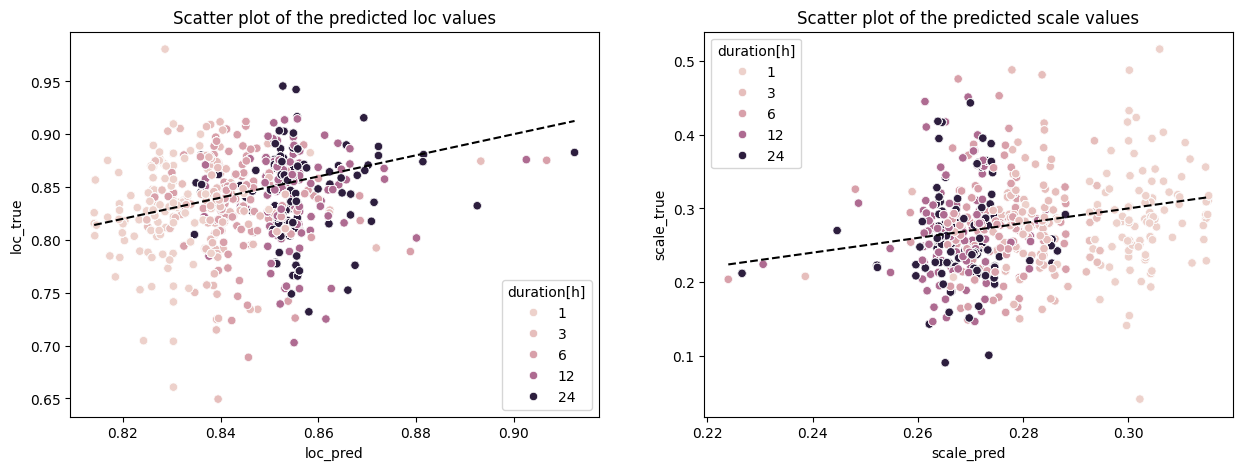

In [64]:
metrics_loc_full, metrics_scale_full = util.parameters_metrics(dist_test_map, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [65]:
print('===============LOC PARAMETER===============')
metrics_loc_full

===============LOC PARAMETER===============


,global,1,3,6,12,24
biasr,-0.011816,-0.005984,-0.013379,-0.008981,-0.015932,-0.014813
rmse,0.001277,0.001152,0.001375,0.001351,0.001314,0.001194
pcc,0.188617,0.157420,-0.019037,-0.027096,0.013074,0.062389


In [66]:
print('===============SCALE PARAMETER==============')
metrics_scale_full

===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,-0.052237,-0.067546,-0.040544,-0.054927,-0.043033,-0.055131
rmse,0.002309,0.002449,0.002281,0.002346,0.002289,0.002179
pcc,0.252773,0.139519,-0.016608,0.047133,0.086720,0.070021


* Metrics on parameters from PCA-model

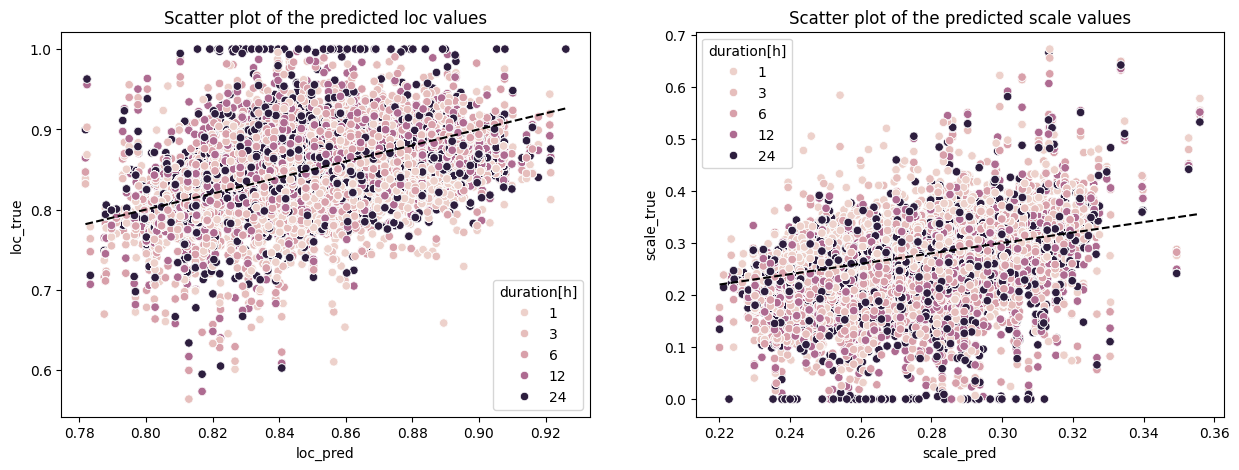

In [67]:
_ = util.parameters_metrics(dist_train_pca, parameters_train, distribution_name = 'gumbel', calculate_metrics = False)

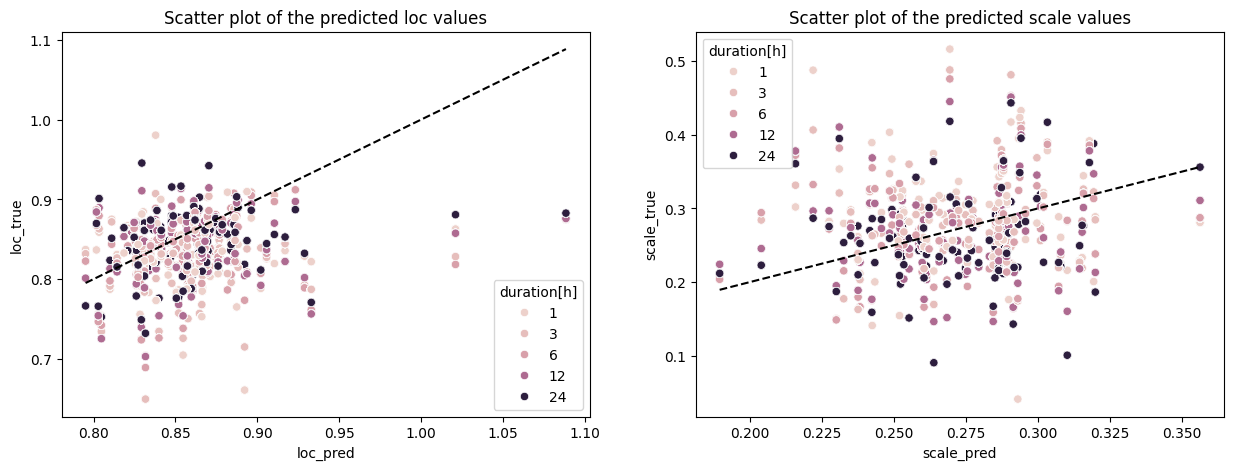

In [68]:
metrics_loc_pca, metrics_scale_pca = util.parameters_metrics(dist_test_pca, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [69]:
print('===============LOC PARAMETER===============')
metrics_loc_pca

===============LOC PARAMETER===============


,global,1,3,6,12,24
biasr,-0.027476,-0.042131,-0.034615,-0.024449,-0.019714,-0.016450
rmse,0.002372,0.002985,0.002613,0.002254,0.002158,0.001850
pcc,0.202775,0.205832,0.223418,0.212184,0.163677,0.235254


In [70]:
print('===============SCALE PARAMETER==============')
metrics_scale_full

===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,-0.052237,-0.067546,-0.040544,-0.054927,-0.043033,-0.055131
rmse,0.002309,0.002449,0.002281,0.002346,0.002289,0.002179
pcc,0.252773,0.139519,-0.016608,0.047133,0.086720,0.070021


### Comparison between two samples extracted from "true" and predicted distribution of the same place 

True loc :  0.9066576729999072 Predicted  loc : 0.8985404
True scale :  0.1750865445495664 Predicted  scale : 0.16177717


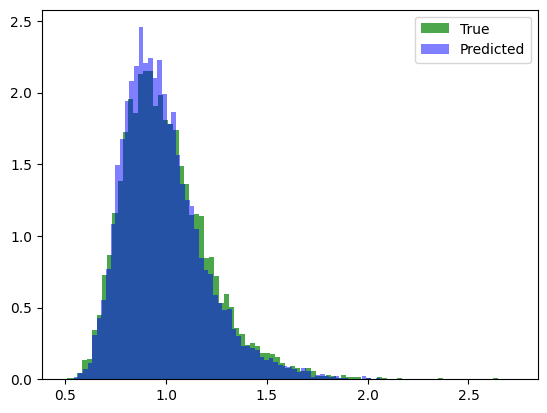

In [62]:
util.compare_samples(dist_train_full, "gumbel", parameters_train, index=9)